In [1]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split

In [2]:
train_path = '../DATA/train_normalized_4labels.csv'
test_path = '../DATA/test_normalized_4labels.csv'

In [3]:
data = pd.read_csv(train_path,index_col=0)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
X = data.drop(columns = ['EMPLOYER_NAME','CASE_STATUS'])
y = data['CASE_STATUS']
T = {'CERTIFIED':0, 'CERTIFIED-WITHDRAWN':1, 'DENIED':2, 'WITHDRAWN':3}
y = list(map(lambda x:T[x],y))

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.05, random_state=42)

In [6]:
train_data = lightgbm.Dataset(X_train, label=y_train)
valid_data = lightgbm.Dataset(X_valid, label=y_valid)

In [7]:
parameters = {
    'objective': 'ova',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'num_class':4,
    'deterministic':'true'
}

In [8]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=valid_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's multi_logloss: 0.384233
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.338526
[3]	valid_0's multi_logloss: 0.323939
[4]	valid_0's multi_logloss: 0.316006
[5]	valid_0's multi_logloss: 0.299488
[6]	valid_0's multi_logloss: 0.281675
[7]	valid_0's multi_logloss: 0.267191
[8]	valid_0's multi_logloss: 0.254878
[9]	valid_0's multi_logloss: 0.252778
[10]	valid_0's multi_logloss: 0.242857
[11]	valid_0's multi_logloss: 0.243258
[12]	valid_0's multi_logloss: 0.234351
[13]	valid_0's multi_logloss: 0.236009
[14]	valid_0's multi_logloss: 0.236622
[15]	valid_0

In [9]:
def calculate_acc(y_test,y_pred):
    labels = [[0,0],[0,0],[0,0],[0,0]] #truth, correct
    for y,yp in zip(y_test,y_pred):
        labels[y][0] += 1
        if y == yp:
            labels[y][1] += 1
    for stat in range(4):
        labels[stat] = labels[stat][1]/labels[stat][0]
    return labels

In [10]:
y_pred = model.predict(X_train).argmax(axis=1)
print("Accuracy on training set:\n",list(zip(['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', 'WITHDRAWN'],
               calculate_acc(y_train,y_pred))))

Accuracy on training set:
 [('CERTIFIED', 0.960469667867315), ('CERTIFIED-WITHDRAWN', 0.9698078839742929), ('DENIED', 0.8084626833935785), ('WITHDRAWN', 0.8286909420359697)]


In [11]:
y_pred = model.predict(X_valid).argmax(axis=1)
print("Accuracy on validation set:\n",list(zip(['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', 'WITHDRAWN'],
               calculate_acc(y_valid,y_pred))))

Accuracy on validation set:
 [('CERTIFIED', 0.9603258048631167), ('CERTIFIED-WITHDRAWN', 0.9667420083952212), ('DENIED', 0.772911597729116), ('WITHDRAWN', 0.8401500938086304)]


In [12]:
data = pd.read_csv(test_path,index_col=0)
X_test = data.drop(columns = ['EMPLOYER_NAME','CASE_STATUS'])
y_test = data['CASE_STATUS']
del(data)
T = {'CERTIFIED':0, 'CERTIFIED-WITHDRAWN':1, 'DENIED':2, 'WITHDRAWN':3}
y_test = list(map(lambda x:T[x],y_test))

In [13]:
y_pred = model.predict(X_test).argmax(axis=1)
print("Accuracy on test set:\n",list(zip(['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', 'WITHDRAWN'],
               calculate_acc(y_test,y_pred))))

Accuracy on test set:
 [('CERTIFIED', 0.960316141704774), ('CERTIFIED-WITHDRAWN', 0.9650138003235937), ('DENIED', 0.7749387139355082), ('WITHDRAWN', 0.821475935828877)]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

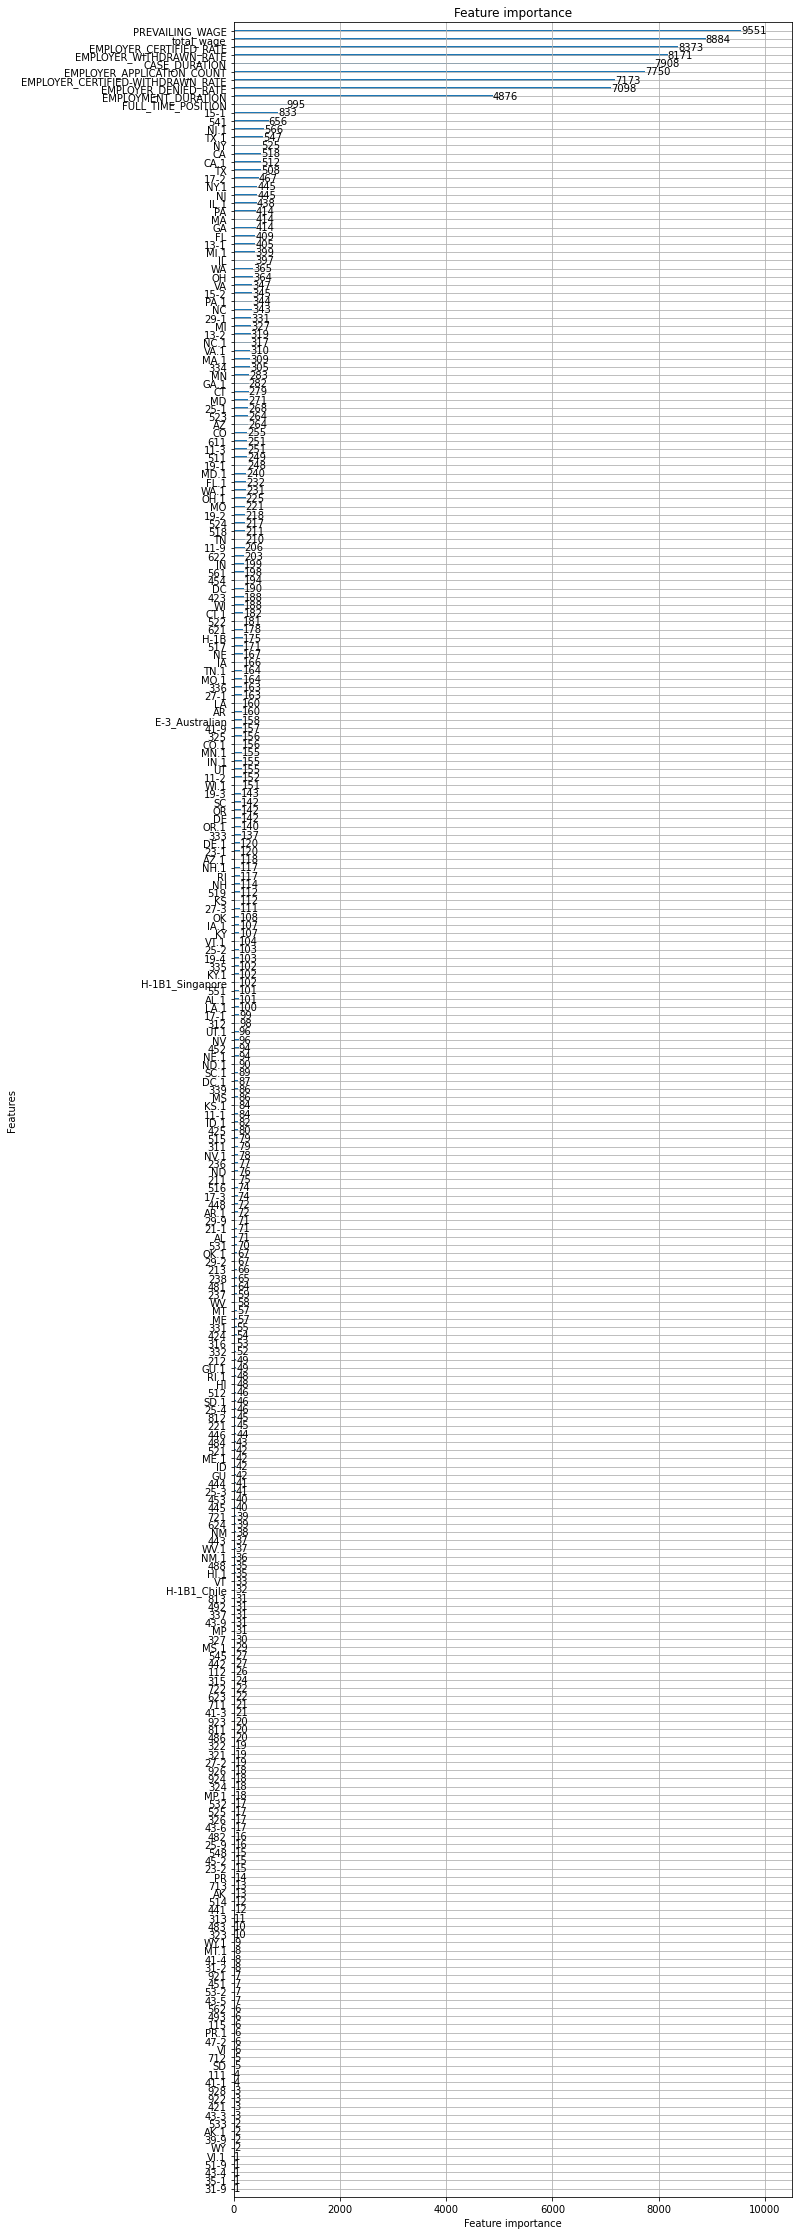

In [14]:
lightgbm.plot_importance(model, figsize=(10, 40))

In [15]:
import pickle
filename = '../saved_models/ensambledTree_ova.sav'
pickle.dump(model, open(filename, 'wb'))
